In [1]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm
from matplotlib import rcParams
import numpy as np
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot
from xgboost import plot_importance
# figure size in inches
rcParams['figure.figsize'] = 15,10


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
!ls

data.zip  Modelling_Guide_for_Predictive_Maintenance_Python.ipynb


In [4]:
path = '/content/'
failures = pd.read_csv(path + 'failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'])
failures['datetime'] =  failures['datetime'] + pd.DateOffset(hours=-1)
machines = pd.read_csv(path +'machines.csv')
maint = pd.read_csv(path +'maint.csv')
errors = pd.read_csv(path +'errors.csv')
telemetry = pd.read_csv(path +'telemetry.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/failures.csv'

## Telemetry

In [ ]:
print(telemetry.shape)
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
print(telemetry.datetime.min())
print(telemetry.datetime.max())
telemetry.head()

(876100, 6)
2015-01-01 06:00:00
2016-01-01 06:00:00


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


## Errors

In [ ]:
print(errors.shape)
errors['datetime'] = pd.to_datetime(errors['datetime'])
print(errors.datetime.min())
print(errors.datetime.max())
errors

(3919, 3)
2015-01-01 06:00:00
2016-01-01 05:00:00


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


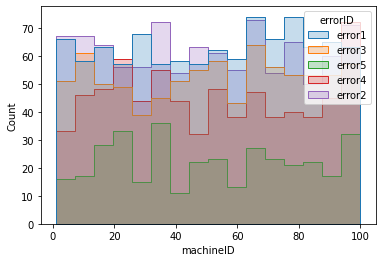

In [ ]:
sns.histplot(data=errors, x="machineID", hue="errorID", element="step")

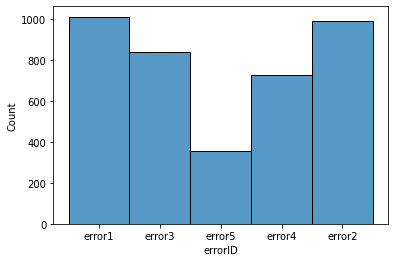

In [ ]:
sns.histplot(data=errors, x="errorID")

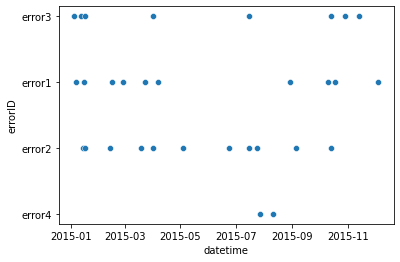

In [ ]:
sns.scatterplot(data=errors[errors.machineID==4], x="datetime", y="errorID")

## Maintenance

In [ ]:
print(maint.shape)
maint['datetime'] = pd.to_datetime(maint['datetime'])
print(maint.datetime.min())
print(maint.datetime.max())
maint

(3286, 3)
2014-06-01 06:00:00
2016-01-01 06:00:00


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


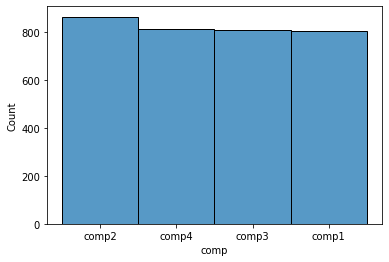

In [ ]:
sns.histplot(data=maint, x="comp")

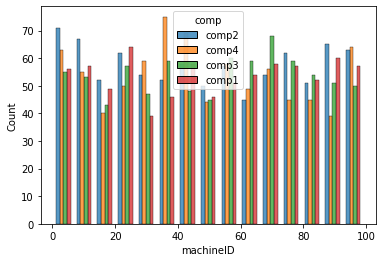

In [ ]:
sns.histplot(data=maint, hue="comp", x='machineID',multiple="dodge",shrink=0.7
             )

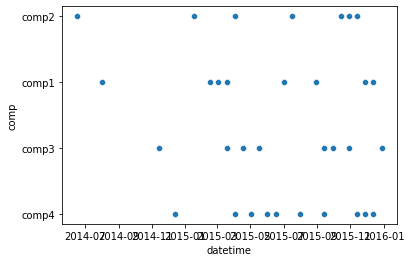

In [ ]:
sns.scatterplot(data=maint[maint.machineID==4], x="datetime", y="comp")

## Machines

In [ ]:
machines

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [ ]:
print(machines.shape)
machines

(100, 3)


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


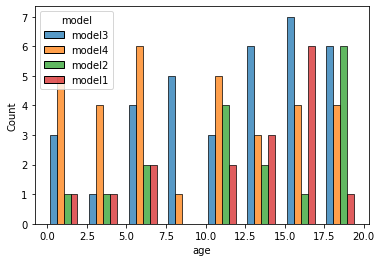

In [ ]:
sns.histplot(data=machines, hue="model", x='age',multiple="dodge",shrink=0.7
             )

## Failures

In [ ]:
print(failures.shape)
failures['datetime'] = pd.to_datetime(failures['datetime'])

print(failures.datetime.min())
print(failures.datetime.max())
failures

(761, 3)
2015-01-02 03:00:00
2015-12-31 06:00:00


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


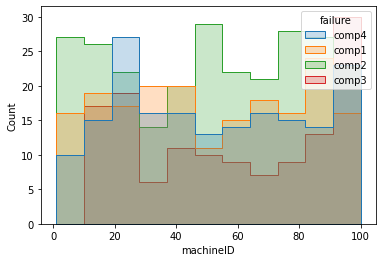

In [ ]:
sns.histplot(data=failures, x="machineID", hue="failure", element="step")

# Feature Engineering

## Lag Features from Telemetry

In [ ]:
telemetrymean = pd.DataFrame(columns=['datetime','machineID','voltmean',
                                        'rotatemean', 'pressuremean','vibrationmean' ])
for i in tqdm(telemetry.machineID.unique()):
    test = telemetry[telemetry.machineID==i]
    
    start=0
    l_w= 3
    end = 2

    while end < test.shape[0]:
        window = test.iloc[start:end].mean(numeric_only=True)
        telemetrymean = telemetrymean.append({'datetime': test.iloc[end].datetime,
                                            'machineID':test.iloc[end].machineID , 
                                            'voltmean':window.volt ,
                                            'rotatemean':window.rotate,
                                            'pressuremean':window.pressure,
                                            'vibrationmean':window.vibration}, 
                                            ignore_index=True)
        start = start + l_w
        end = end + l_w
        #print(start, end)



In [ ]:
telemetrymean = pd.read_csv(path+'telemetrymean.csv').drop(columns=['Unnamed: 0'])

In [ ]:
telemetrymean

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean
0,2015-01-01 08:00:00,1,169.548538,410.625784,104.269230,44.250829
1,2015-01-01 11:00:00,1,160.036427,390.763104,110.567605,33.556328
2,2015-01-01 14:00:00,1,164.539406,454.348170,106.378384,39.117964
3,2015-01-01 17:00:00,1,168.139702,421.667106,104.314446,41.288768
4,2015-01-01 20:00:00,1,168.046302,454.436086,89.748697,42.737872
...,...,...,...,...,...,...
291995,2015-12-31 17:00:00,100,171.128067,418.692757,101.851125,47.374256
291996,2015-12-31 20:00:00,100,167.719466,428.957543,107.724134,32.632688
291997,2015-12-31 23:00:00,100,161.400960,549.078579,103.369992,38.181204
291998,2016-01-01 02:00:00,100,165.741354,460.369010,102.373984,45.835877


In [ ]:
telemetrysd = pd.DataFrame(columns=['datetime','machineID','voltsd',
                                        'rotatesd', 'pressuresd','vibrationsd' ])
for i in tqdm(telemetry.machineID.unique()):
    test = telemetry[telemetry.machineID==i]
    
    start=0
    l_w= 3
    end = 2

    while end < test.shape[0]:
        window = test.iloc[start:end].std(numeric_only=True)
        telemetrysd = telemetrysd.append({'datetime': test.iloc[end].datetime,
                                            'machineID':test.iloc[end].machineID , 
                                            'voltsd':window.volt ,
                                            'rotatesd':window.rotate,
                                            'pressuresd':window.pressure,
                                            'vibrationsd':window.vibration}, 
                                            ignore_index=True)
        start = start + l_w
        end = end + l_w
        #print(start, end)



KeyboardInterrupt: ignored

In [ ]:
telemetrysd = pd.read_csv(path+'telemetrysd.csv').drop(columns=['Unnamed: 0'])

In [ ]:
telemetrysd

,datetime,machineID,voltsd,rotatesd,pressuresd,vibrationsd
0,2015-01-01 08:00:00,1,9.431836,11.141591,12.457390,1.183494
1,2015-01-01 11:00:00,1,3.431456,63.093397,1.865409,10.699680
2,2015-01-01 14:00:00,1,11.290197,63.248514,7.604652,5.142018
3,2015-01-01 17:00:00,1,1.525542,55.413927,0.754884,1.961560
4,2015-01-01 20:00:00,1,20.778772,51.246623,5.283865,1.938438
...,...,...,...,...,...,...
291995,2015-12-31 17:00:00,100,9.049406,42.711821,2.952868,4.890286
291996,2015-12-31 20:00:00,100,41.313941,97.444500,6.789504,3.160070
291997,2015-12-31 23:00:00,100,11.308598,4.149312,5.992076,0.727468
291998,2016-01-01 02:00:00,100,4.240781,29.535706,1.109096,2.055027


In [ ]:
telemetrymean_24hrs = pd.DataFrame(columns=['datetime','machineID','voltmean_24hrs',
                                        'rotatemean_24hrs', 'pressuremean_24hrs','vibrationmean_24hrs' ])
for i in tqdm(telemetry.machineID.unique()):
    test = telemetry[telemetry.machineID==i].copy()
    
    start=0
    l_w= 3
    end = 23

    while end < test.shape[0]:
        window = test.iloc[start:end].mean(numeric_only=True)
        telemetrymean_24hrs = telemetrymean_24hrs.append({'datetime': test.iloc[end].datetime,
                                            'machineID':test.iloc[end].machineID , 
                                            'voltmean_24hrs':window.volt ,
                                            'rotatemean_24hrs':window.rotate,
                                            'pressuremean_24hrs':window.pressure,
                                            'vibrationmean_24hrs':window.vibration}, 
                                            ignore_index=True)
        start = start + l_w
        end = end + l_w


In [ ]:
telemetrymean_24hrs = pd.read_csv(path+'telemetrymean_24hrs.csv').drop(columns=['Unnamed: 0'])

In [ ]:
telemetrymean_24hrs

,datetime,machineID,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs
0,2015-01-02 05:00:00,1,169.232778,442.979948,96.943105,39.864694
1,2015-01-02 08:00:00,1,170.960368,442.056751,98.133465,39.647285
2,2015-01-02 11:00:00,1,169.904296,446.760489,96.872698,40.142574
3,2015-01-02 14:00:00,1,171.121156,445.160302,95.994210,40.324431
4,2015-01-02 17:00:00,1,170.301879,453.364311,96.091003,39.892518
...,...,...,...,...,...,...
291295,2015-12-31 17:00:00,100,169.742508,456.904680,101.566765,39.563145
291296,2015-12-31 20:00:00,100,168.946921,454.159337,102.210081,38.874563
291297,2015-12-31 23:00:00,100,169.178167,465.382356,101.168718,38.603431
291298,2016-01-01 02:00:00,100,170.236422,465.148367,101.376912,39.485513


In [ ]:


telemetrysd_24hrs = pd.DataFrame(columns=['datetime','machineID','voltsd_24hrs',
                                        'rotatesd_24hrs', 'pressuresd_24hrs','vibrationsd_24hrs' ])
for i in tqdm(telemetry.machineID.unique()):
    test = telemetry[telemetry.machineID==i].copy()
    
    start=0
    l_w= 3
    end = 23

    while end < test.shape[0]:
        window = test.iloc[start:end].std(numeric_only=True)
        telemetrysd_24hrs = telemetrysd_24hrs.append({'datetime': test.iloc[end].datetime,
                                            'machineID':test.iloc[end].machineID , 
                                            'voltsd_24hrs':window.volt ,
                                            'rotatesd_24hrs':window.rotate,
                                            'pressuresd_24hrs':window.pressure,
                                            'vibrationsd_24hrs':window.vibration}, 
                                            ignore_index=True)
        start = start + l_w
        end = end + l_w

In [ ]:
telemetrysd_24hrs =  pd.read_csv(path+'telemetrysd_24hrs.csv').drop(columns=['Unnamed: 0'])

In [ ]:
telemetrysd_24hrs

,datetime,machineID,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
0,2015-01-02 05:00:00,1,11.208031,48.578131,10.280446,5.387075
1,2015-01-02 08:00:00,1,12.689530,47.081634,9.330394,6.196015
2,2015-01-02 11:00:00,1,13.556182,43.773874,9.273836,5.569241
3,2015-01-02 14:00:00,1,13.577865,42.367299,8.359675,5.644871
4,2015-01-02 17:00:00,1,15.076988,43.062922,8.763408,6.019957
...,...,...,...,...,...,...
291295,2015-12-31 17:00:00,100,15.256318,61.094578,7.587182,5.228637
291296,2015-12-31 20:00:00,100,17.476467,64.229106,7.958815,5.584182
291297,2015-12-31 23:00:00,100,17.339977,67.815177,9.174844,5.688653
291298,2016-01-01 02:00:00,100,16.661846,65.778793,9.026573,5.826045


In [ ]:
telemetry.head(10)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
5,2015-01-01 11:00:00,1,172.504839,430.323362,95.927042,35.655017
6,2015-01-01 12:00:00,1,156.556031,499.071623,111.755684,42.753920
7,2015-01-01 13:00:00,1,172.522781,409.624717,101.001083,35.482009
8,2015-01-01 14:00:00,1,175.324524,398.648781,110.624361,45.482287
9,2015-01-01 15:00:00,1,169.218423,460.850670,104.848230,39.901735


In [ ]:
telemetryfeat = telemetrymean.merge(telemetrysd, on = ['datetime', 'machineID'])
telemetryfeat = telemetryfeat.merge(telemetrymean_24hrs, on = ['datetime', 'machineID'])
telemetryfeat = telemetryfeat.merge(telemetrysd_24hrs, on = ['datetime', 'machineID'])
telemetryfeat 

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
0,2015-01-02 05:00:00,1,179.571915,413.023501,94.487309,36.149377,30.123477,13.841687,2.896560,5.137187,169.232778,442.979948,96.943105,39.864694,11.208031,48.578131,10.280446,5.387075
1,2015-01-02 08:00:00,1,184.282010,415.794954,108.857677,32.662115,18.499490,44.051328,7.756090,4.432783,170.960368,442.056751,98.133465,39.647285,12.689530,47.081634,9.330394,6.196015
2,2015-01-02 11:00:00,1,153.879590,416.788244,100.560170,35.583404,9.303987,5.405899,13.928328,1.952127,169.904296,446.760489,96.872698,40.142574,13.556182,43.773874,9.273836,5.569241
3,2015-01-02 14:00:00,1,179.498304,415.480685,102.750033,45.391910,8.070990,42.604260,4.586597,3.493919,171.121156,445.160302,95.994210,40.324431,13.577865,42.367299,8.359675,5.644871
4,2015-01-02 17:00:00,1,162.639600,491.135021,102.847207,40.261015,24.594750,5.998285,12.874124,4.014589,170.301879,453.364311,96.091003,39.892518,15.076988,43.062922,8.763408,6.019957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291295,2015-12-31 17:00:00,100,171.128067,418.692757,101.851125,47.374256,9.049406,42.711821,2.952868,4.890286,169.742508,456.904680,101.566765,39.563145,15.256318,61.094578,7.587182,5.228637
291296,2015-12-31 20:00:00,100,167.719466,428.957543,107.724134,32.632688,41.313941,97.444500,6.789504,3.160070,168.946921,454.159337,102.210081,38.874563,17.476467,64.229106,7.958815,5.584182
291297,2015-12-31 23:00:00,100,161.400960,549.078579,103.369992,38.181204,11.308598,4.149312,5.992076,0.727468,169.178167,465.382356,101.168718,38.603431,17.339977,67.815177,9.174844,5.688653
291298,2016-01-01 02:00:00,100,165.741354,460.369010,102.373984,45.835877,4.240781,29.535706,1.109096,2.055027,170.236422,465.148367,101.376912,39.485513,16.661846,65.778793,9.026573,5.826045


In [ ]:
telemetrymean.to_csv(path + 'telemetrymean.csv')
telemetrysd.to_csv(path +'telemetrysd.csv')
telemetrymean_24hrs.to_csv(path +'telemetrymean_24hrs.csv')
telemetrysd_24hrs.to_csv(path +'telemetrysd_24hrs.csv')

In [ ]:
telemetryfeat.to_csv(path +'telemetryfeat.csv')


In [ ]:
telemetryfeat = pd.read_csv(path +'telemetryfeat.csv').drop(columns=['Unnamed: 0'])
telemetryfeat['datetime'] = telemetryfeat['datetime'].astype('datetime64[ns]')

## Lag Features from Errors

In [ ]:
errorcount  = pd.get_dummies(errors, prefix=['sum'])
errorcount.groupby(by=['machineID','datetime' ]).sum().reset_index()

,machineID,datetime,sum_error1,sum_error2,sum_error3,sum_error4,sum_error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
...,...,...,...,...,...,...,...
3611,100,2015-11-12 01:00:00,1,0,0,0,0
3612,100,2015-11-21 08:00:00,0,1,0,0,0
3613,100,2015-12-04 02:00:00,1,0,0,0,0
3614,100,2015-12-08 06:00:00,0,1,1,0,0


In [ ]:
errorcount[errorcount.machineID==1].datetime.min()

Timestamp('2015-01-03 07:00:00')

In [ ]:
telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [ ]:
errorfeat  = telemetry[['datetime','machineID']].merge(errorcount, how='left', on=['datetime','machineID'])
errorfeat = errorfeat.fillna(0)
errorfeat

,datetime,machineID,sum_error1,sum_error2,sum_error3,sum_error4,sum_error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
876398,2016-01-01 02:00:00,100,0.0,0.0,0.0,0.0,0.0
876399,2016-01-01 03:00:00,100,0.0,0.0,0.0,0.0,0.0
876400,2016-01-01 04:00:00,100,0.0,0.0,0.0,0.0,0.0
876401,2016-01-01 05:00:00,100,0.0,0.0,0.0,0.0,0.0


In [ ]:
errorfeat.describe()

,machineID,sum_error1,sum_error2,sum_error3,sum_error4,sum_error5
count,876403.000000,876403.000000,876403.000000,876403.000000,876403.00000,876403.000000
mean,50.499881,0.001152,0.001127,0.000956,0.00083,0.000406
std,28.866464,0.033928,0.033557,0.030907,0.02879,0.020150
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,50.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,76.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [ ]:
temp = pd.DataFrame(columns=['datetime','machineID','error1count',
                                        'error2count', 'error3count','error4count',
                              'error5count'])
for i in tqdm(errorfeat.machineID.unique()):
    test = errorfeat[errorfeat.machineID==i].copy()
    
    start=0
    l_w= 3
    end = 23

    while end < test.shape[0]:
        window = test.iloc[start:end].sum(numeric_only=True)
        temp = temp.append({'datetime': test.iloc[end].datetime,
                                            'machineID':test.iloc[end].machineID , 
                                            'error1count':window.sum_error1 ,
                                            'error2count':window.sum_error2,
                                            'error3count':window.sum_error3,
                                            'error4count':window.sum_error4,
                                            'error5count': window.sum_error5}, 
                                            ignore_index=True)
        start = start + l_w
        end = end + l_w


In [ ]:
temp

,datetime,machineID,error1count,error2count,error3count,error4count,error5count
0,2015-01-02 05:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-02 08:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-02 11:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-02 14:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-02 17:00:00,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
291397,2015-12-31 16:00:00,100,0.0,0.0,0.0,0.0,0.0
291398,2015-12-31 19:00:00,100,0.0,0.0,0.0,0.0,0.0
291399,2015-12-31 22:00:00,100,0.0,0.0,0.0,0.0,0.0
291400,2016-01-01 01:00:00,100,0.0,0.0,0.0,0.0,0.0


In [ ]:
errorfeat = temp

In [ ]:
errorfeat.to_csv('errorfeat.csv')

In [ ]:
errorfeat = pd.read_csv(path + 'errorfeat.csv').drop(columns=['Unnamed: 0'])

In [ ]:
errorfeat

,datetime,machineID,error1count,error2count,error3count,error4count,error5count
0,2015-01-02 05:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-02 08:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-02 11:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-02 14:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-02 17:00:00,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
291397,2015-12-31 16:00:00,100,0.0,0.0,0.0,0.0,0.0
291398,2015-12-31 19:00:00,100,0.0,0.0,0.0,0.0,0.0
291399,2015-12-31 22:00:00,100,0.0,0.0,0.0,0.0,0.0
291400,2016-01-01 01:00:00,100,0.0,0.0,0.0,0.0,0.0


## Days Since Last Replacement from Maintenance

In [ ]:
comprep  = pd.get_dummies(maint).groupby(by = ['machineID','datetime']).sum().reset_index()
#comprep  = comprep.groupby(by=['machineID','datetime' ])
comprep['datetime'] = comprep['datetime'].astype('datetime64[ns]')
comprep.head(10)

,machineID,datetime,comp_comp1,comp_comp2,comp_comp3,comp_comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1
5,1,2015-01-20 06:00:00,1,0,1,0
6,1,2015-02-04 06:00:00,0,0,1,1
7,1,2015-02-19 06:00:00,0,0,1,0
8,1,2015-03-06 06:00:00,1,0,0,0
9,1,2015-03-21 06:00:00,1,0,0,0


In [ ]:


compfeat_temp = pd.DataFrame()

for k in tqdm(comprep.machineID.unique()):
    test =  comprep[comprep.machineID==k].copy()
    test.index = range(test.shape[0])
    for col in ['comp_comp1','comp_comp2','comp_comp3','comp_comp4']:
        last = 0
        for i in range(test.shape[0]):
            #print(i, k, col)
            if test.loc[i,col] == 1:
                test.loc[i,col+'since'] = (test.iloc[i].datetime - test.iloc[last].datetime).days
                last =i
            else:
                test.loc[i,col+'since'] = (test.iloc[i].datetime - test.iloc[last].datetime).days
    test['datetime'] =  test['datetime'] + pd.DateOffset(hours=-1)

    compfeat_temp = compfeat_temp.append(test, ignore_index = True)

compfeat_temp

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,machineID,datetime,comp_comp1,comp_comp2,comp_comp3,comp_comp4,comp_comp1since,comp_comp2since,comp_comp3since,comp_comp4since
0,1,2014-06-01 05:00:00,0,1,0,0,0.0,0.0,0.0,0.0
1,1,2014-07-16 05:00:00,0,0,0,1,45.0,45.0,45.0,45.0
2,1,2014-07-31 05:00:00,0,0,1,0,60.0,60.0,60.0,15.0
3,1,2014-12-13 05:00:00,1,0,0,0,195.0,195.0,135.0,150.0
4,1,2015-01-05 05:00:00,1,0,0,1,23.0,218.0,158.0,173.0
...,...,...,...,...,...,...,...,...,...,...
2523,100,2015-10-10 05:00:00,1,0,1,0,15.0,75.0,60.0,45.0
2524,100,2015-10-25 05:00:00,0,0,0,1,15.0,90.0,15.0,60.0
2525,100,2015-11-09 05:00:00,0,0,0,1,30.0,105.0,30.0,15.0
2526,100,2015-12-09 05:00:00,0,1,0,0,60.0,135.0,60.0,30.0


In [ ]:
compfeat_temp

,machineID,datetime,comp_comp1,comp_comp2,comp_comp3,comp_comp4,comp_comp1since,comp_comp2since,comp_comp3since,comp_comp4since
0,1,2014-06-01 05:00:00,0,1,0,0,0.0,0.0,0.0,0.0
1,1,2014-07-16 05:00:00,0,0,0,1,45.0,45.0,45.0,45.0
2,1,2014-07-31 05:00:00,0,0,1,0,60.0,60.0,60.0,15.0
3,1,2014-12-13 05:00:00,1,0,0,0,195.0,195.0,135.0,150.0
4,1,2015-01-05 05:00:00,1,0,0,1,23.0,218.0,158.0,173.0
...,...,...,...,...,...,...,...,...,...,...
2523,100,2015-10-10 05:00:00,1,0,1,0,15.0,75.0,60.0,45.0
2524,100,2015-10-25 05:00:00,0,0,0,1,15.0,90.0,15.0,60.0
2525,100,2015-11-09 05:00:00,0,0,0,1,30.0,105.0,30.0,15.0
2526,100,2015-12-09 05:00:00,0,1,0,0,60.0,135.0,60.0,30.0


In [ ]:
compfeat_temp = compfeat_temp.merge(telemetryfeat[['machineID','datetime']], on= ['datetime','machineID'], how= 'right')#.drop_duplicates(keep='first')#
compfeat_temp = compfeat_temp.drop(columns=['comp_comp1','comp_comp2'	,'comp_comp3' ,'comp_comp4'])
compfeat_temp =compfeat_temp.fillna(0)
#compfeat_temp.head(50)

,machineID,datetime,comp_comp1since,comp_comp2since,comp_comp3since,comp_comp4since
0,1,2015-01-02 05:00:00,0.0,0.0,0.0,0.0
1,1,2015-01-02 08:00:00,0.0,0.0,0.0,0.0
2,1,2015-01-02 11:00:00,0.0,0.0,0.0,0.0
3,1,2015-01-02 14:00:00,0.0,0.0,0.0,0.0
4,1,2015-01-02 17:00:00,0.0,0.0,0.0,0.0
5,1,2015-01-02 20:00:00,0.0,0.0,0.0,0.0
6,1,2015-01-02 23:00:00,0.0,0.0,0.0,0.0
7,1,2015-01-03 02:00:00,0.0,0.0,0.0,0.0
8,1,2015-01-03 05:00:00,0.0,0.0,0.0,0.0
9,1,2015-01-03 08:00:00,0.0,0.0,0.0,0.0


In [ ]:
compfeat= pd.DataFrame()

for k in tqdm(compfeat_temp.machineID.unique()):
    test =  compfeat_temp[compfeat_temp.machineID==k].copy()
    test.index = range(test.shape[0])    
    for col in ['comp_comp1since', 'comp_comp2since','comp_comp3since','comp_comp4since']:
        start = 0
        for i in range(test.shape[0]):
            if test.loc[i, col] !=0:
                for j in range(start, i+1):
                    dif = (test.iloc[i].datetime - test.iloc[j].datetime)
                    test.loc[j, col + '_2'] =  test.loc[i, col] - dif/np.timedelta64(1,'h')/24  
                start = i+1
            elif i ==test.shape[0]-1:
                n = 1
                for j in range(start, test.shape[0]):
                    dif =n*0.3
                    test.loc[j, col + '_2'] =  dif
                    n +=1





    compfeat = compfeat.append(test, ignore_index = True)
compfeat = compfeat[[ 'datetime','machineID',  'comp_comp1since_2',
       'comp_comp2since_2', 'comp_comp3since_2', 'comp_comp4since_2']]
compfeat.columns = [ 'datetime','machineID',  'sincelastcomp1','sincelastcomp2', 'sincelastcomp3', 'sincelastcomp4']

In [ ]:
compfeat.head(20)

,datetime,machineID,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
0,2015-01-02 05:00:00,1,20.000,215.000,155.000,170.000
1,2015-01-02 08:00:00,1,20.125,215.125,155.125,170.125
2,2015-01-02 11:00:00,1,20.250,215.250,155.250,170.250
3,2015-01-02 14:00:00,1,20.375,215.375,155.375,170.375
4,2015-01-02 17:00:00,1,20.500,215.500,155.500,170.500
5,2015-01-02 20:00:00,1,20.625,215.625,155.625,170.625
6,2015-01-02 23:00:00,1,20.750,215.750,155.750,170.750
7,2015-01-03 02:00:00,1,20.875,215.875,155.875,170.875
8,2015-01-03 05:00:00,1,21.000,216.000,156.000,171.000
9,2015-01-03 08:00:00,1,21.125,216.125,156.125,171.125


In [ ]:
compfeat.tail(20)

,datetime,machineID,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
291280,2015-12-29 20:00:00,100,13.5,13.5,13.5,13.5
291281,2015-12-29 23:00:00,100,13.8,13.8,13.8,13.8
291282,2015-12-30 02:00:00,100,14.1,14.1,14.1,14.1
291283,2015-12-30 05:00:00,100,14.4,14.4,14.4,14.4
291284,2015-12-30 08:00:00,100,14.7,14.7,14.7,14.7
291285,2015-12-30 11:00:00,100,15.0,15.0,15.0,15.0
291286,2015-12-30 14:00:00,100,15.3,15.3,15.3,15.3
291287,2015-12-30 17:00:00,100,15.6,15.6,15.6,15.6
291288,2015-12-30 20:00:00,100,15.9,15.9,15.9,15.9
291289,2015-12-30 23:00:00,100,16.2,16.2,16.2,16.2


In [ ]:
compfeat.to_csv(path + 'compfeat.csv')

## Machine Features

In [ ]:
errorfeat['datetime'] = errorfeat['datetime'].astype('datetime64[ns]')
finalfeat = telemetryfeat.merge(errorfeat, on = ['datetime', 'machineID'])
finalfeat = finalfeat.merge(compfeat,on = ['datetime', 'machineID'] )
finalfeat = finalfeat.merge(machines,on = [ 'machineID'] )
finalfeat = finalfeat.drop(columns=['day'])
finalfeat.to_csv(path + 'finalfeat.csv')

In [ ]:
finalfeat.columns

Index(['datetime', 'machineID', 'voltmean', 'rotatemean', 'pressuremean',
       'vibrationmean', 'voltsd', 'rotatesd', 'pressuresd', 'vibrationsd',
       'voltmean_24hrs', 'rotatemean_24hrs', 'pressuremean_24hrs',
       'vibrationmean_24hrs', 'voltsd_24hrs', 'rotatesd_24hrs',
       'pressuresd_24hrs', 'vibrationsd_24hrs', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'sincelastcomp1',
       'sincelastcomp2', 'sincelastcomp3', 'sincelastcomp4', 'model', 'age'],
      dtype='object')

In [ ]:
finalfeat.head()

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs,error1count,error2count,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age
0,2015-01-02 05:00:00,1,179.571915,413.023501,94.487309,36.149377,30.123477,13.841687,2.896560,5.137187,169.232778,442.979948,96.943105,39.864694,11.208031,48.578131,10.280446,5.387075,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,2015-01-02 08:00:00,1,184.282010,415.794954,108.857677,32.662115,18.499490,44.051328,7.756090,4.432783,170.960368,442.056751,98.133465,39.647285,12.689530,47.081634,9.330394,6.196015,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,2015-01-02 11:00:00,1,153.879590,416.788244,100.560170,35.583404,9.303987,5.405899,13.928328,1.952127,169.904296,446.760489,96.872698,40.142574,13.556182,43.773874,9.273836,5.569241,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,2015-01-02 14:00:00,1,179.498304,415.480685,102.750033,45.391910,8.070990,42.604260,4.586597,3.493919,171.121156,445.160302,95.994210,40.324431,13.577865,42.367299,8.359675,5.644871,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
4,2015-01-02 17:00:00,1,162.639600,491.135021,102.847207,40.261015,24.594750,5.998285,12.874124,4.014589,170.301879,453.364311,96.091003,39.892518,15.076988,43.062922,8.763408,6.019957,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18


## Label construction

In [ ]:

labeled = finalfeat.merge(failures, on=['machineID', 'datetime'], how='left')
labeled['failure'] = labeled.failure.fillna('none')

In [ ]:
labeled[labeled.failure == 'comp4'].head(50)

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs,error1count,error2count,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age,failure
24,2015-01-05 05:00:00,1,189.918854,424.403282,98.871276,47.548497,17.821402,52.888708,5.918580,3.317957,171.065003,440.072790,97.982275,51.261272,21.719698,34.241033,9.679396,5.127365,0.0,0.0,0.0,0.0,1.0,23.0,218.0,158.0,173.0,model3,18,comp4
19484,2015-04-01 05:00:00,17,162.034759,381.154861,95.093232,45.585182,6.050750,42.282766,0.602134,0.268878,167.260637,371.884656,95.786061,50.164951,16.174851,44.612832,8.663363,4.197932,0.0,0.0,0.0,0.0,1.0,45.0,45.0,15.0,60.0,model1,14,comp4
20829,2015-01-30 05:00:00,18,173.573605,492.002937,96.343004,45.392659,0.178177,66.684133,10.230757,4.041451,175.506814,445.058574,100.838143,47.793989,11.090876,41.441935,10.744170,4.772189,0.0,0.0,0.0,0.0,1.0,63.0,168.0,243.0,228.0,model3,15,comp4
21669,2015-05-15 05:00:00,18,181.024553,393.041903,105.257801,49.851484,21.029163,79.746449,9.994613,2.828024,170.264050,457.975582,97.443814,50.758484,16.063238,55.082159,10.261648,3.782116,0.0,0.0,0.0,0.0,1.0,30.0,75.0,30.0,90.0,model3,15,comp4
22389,2015-10-27 05:00:00,18,198.653801,429.266454,111.880168,48.765711,2.029419,23.276184,23.298778,2.949133,207.454308,447.199772,100.692866,51.332884,16.927894,52.677252,9.925835,6.170649,0.0,0.0,0.0,0.0,1.0,15.0,45.0,90.0,45.0,model3,15,comp4
23366,2015-02-27 05:00:00,19,174.489192,437.721901,114.209248,50.530765,4.364622,30.220017,5.438248,1.611210,175.997182,453.333577,100.798720,50.247867,13.156204,50.894004,10.642418,4.614542,0.0,0.0,0.0,0.0,1.0,15.0,30.0,76.0,271.0,model3,17,comp4
23726,2015-04-13 05:00:00,19,152.536633,568.240296,97.987226,48.563313,4.899300,29.583509,4.740709,2.696116,168.079679,466.017519,98.795287,50.079450,13.326591,59.373934,7.545262,4.534889,0.0,0.0,0.0,0.0,1.0,60.0,75.0,30.0,45.0,model3,17,comp4
24326,2015-06-27 05:00:00,19,148.251115,487.576974,99.159537,53.372413,32.195949,36.125843,0.968436,4.679383,160.504842,447.841832,96.815152,50.333040,15.257675,46.560415,7.886804,4.696201,0.0,0.0,0.0,0.0,1.0,15.0,30.0,60.0,75.0,model3,17,comp4
24926,2015-09-10 05:00:00,19,170.240934,488.666061,102.782434,49.343596,1.259717,7.928070,7.797789,9.513166,170.982083,442.680455,102.181796,49.698419,12.051129,75.365010,9.563068,5.710549,0.0,0.0,0.0,0.0,1.0,30.0,75.0,15.0,75.0,model3,17,comp4
25526,2015-11-24 05:00:00,19,179.348857,443.258032,99.077080,53.246903,25.104810,82.048239,13.321097,1.797827,171.501318,438.481492,98.563551,49.361098,17.872648,42.615614,9.301636,3.977598,0.0,0.0,0.0,0.0,1.0,105.0,30.0,45.0,75.0,model3,17,comp4


In [ ]:
for i in tqdm(range(labeled.shape[0])):
    if labeled.loc[i, 'failure']!='none':
        for j in range(1,8):
            labeled.loc[i-j, 'failure'] = labeled.loc[i, 'failure']
labeledfeatures = labeled.copy()

In [ ]:
labeledfeatures.to_csv(path + 'labeledfeatures.csv')

In [ ]:
labeledfeatures[labeledfeatures.failure == 'comp4'].head(16)

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs,error1count,error2count,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age,failure
17,2015-01-04 08:00:00,1,153.838304,440.874168,108.281541,51.543836,15.799362,10.740485,14.950941,4.673827,170.962175,442.950553,101.163459,52.592454,14.402911,37.183333,10.673330,5.924468,0.0,0.0,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
18,2015-01-04 11:00:00,1,155.289911,439.126998,103.812904,55.553311,3.035401,1.464682,13.135230,2.627279,170.042053,445.094948,102.352478,53.070298,14.610474,37.021895,10.430717,5.874084,0.0,0.0,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
19,2015-01-04 14:00:00,1,171.513220,438.094252,96.146551,48.204823,2.845538,23.144825,6.322915,3.186893,171.343961,444.196956,102.049096,51.786077,16.947451,36.190923,9.590802,5.143057,0.0,0.0,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
20,2015-01-04 17:00:00,1,176.571809,410.375336,85.581923,47.983007,11.410819,63.868051,2.675814,5.748983,171.642210,441.523380,101.444944,51.995149,18.757251,39.930809,10.369023,5.050210,0.0,0.0,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
21,2015-01-04 20:00:00,1,191.720408,420.156862,109.509869,49.256026,11.364020,8.026650,3.075617,10.721350,174.793731,441.316473,102.465255,51.242003,19.270330,39.690354,10.800774,5.375265,0.0,0.0,0.0,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,comp4
22,2015-01-04 23:00:00,1,171.465824,452.796634,92.504407,51.090980,12.864930,8.054277,4.588100,1.203403,175.130196,447.767036,101.973049,51.743579,19.583776,34.426836,10.738210,4.688964,0.0,0.0,0.0,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,comp4
23,2015-01-05 02:00:00,1,144.546279,403.597395,92.818383,52.466544,24.582792,38.010935,4.028804,7.949215,171.946989,443.410658,99.344577,51.809189,21.539320,37.093076,10.280544,5.141780,0.0,0.0,0.0,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,comp4
24,2015-01-05 05:00:00,1,189.918854,424.403282,98.871276,47.548497,17.821402,52.888708,5.918580,3.317957,171.065003,440.072790,97.982275,51.261272,21.719698,34.241033,9.679396,5.127365,0.0,0.0,0.0,0.0,1.0,23.000,218.000,158.000,173.000,model3,18,comp4
19477,2015-03-31 11:00:00,17,172.439929,436.800662,94.951436,49.367130,11.286149,15.473853,9.528775,2.529011,169.079940,366.041853,100.550030,51.640017,16.941622,52.005379,12.419819,4.641955,0.0,1.0,1.0,0.0,1.0,44.250,44.250,14.250,59.250,model1,14,comp4
19478,2015-03-31 14:00:00,17,176.262713,419.790236,101.179599,53.488356,6.973326,10.404345,2.730160,3.193411,167.279688,371.110416,99.576025,51.704039,14.841005,54.795023,11.825258,4.612262,0.0,1.0,1.0,0.0,1.0,44.375,44.375,14.375,59.375,model1,14,comp4


# Modeling

In [ ]:
labeledfeatures= pd.read_csv(path + 'labeledfeatures.csv').drop(columns=['Unnamed: 0'])
labeledfeatures.shape

In [ ]:
labeledfeatures.describe()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs,error1count,error2count,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,age
count,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000,133879.000000
mean,49.322343,170.759839,446.976272,100.844890,40.365305,11.959054,39.986695,8.030114,3.986637,170.795057,447.094838,100.850702,40.355667,14.907081,49.801340,10.045654,4.988284,0.027510,0.022543,0.019219,0.019787,0.009083,56.742092,71.269979,58.312577,58.385785,11.267436
std,28.547099,11.317752,38.621678,8.506260,4.006533,9.078935,30.147550,6.065526,3.014745,4.804466,17.505749,4.808054,2.025139,2.321043,7.777115,1.741045,0.805437,0.165697,0.150142,0.138701,0.140760,0.095342,65.806612,74.066432,64.199850,65.052281,5.653719
min,1.000000,112.522895,182.247316,66.317729,24.293316,0.000389,0.000329,0.000024,0.000091,157.285455,266.439346,90.851038,35.379404,6.928380,21.594462,4.530920,2.120626,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.000000
25%,25.000000,163.178025,423.172404,95.379906,37.724807,4.748963,15.984496,3.209559,1.585276,168.041469,441.621236,98.616235,39.333427,13.298484,44.466368,8.899683,4.441140,0.000000,0.000000,0.000000,0.000000,0.000000,13.125000,15.125000,13.125000,12.750000,7.000000
50%,48.000000,170.440080,448.291988,100.277894,40.162068,10.081851,33.737814,6.782429,3.364363,170.226166,449.330462,100.068216,40.062847,14.835759,49.439962,9.923544,4.946122,0.000000,0.000000,0.000000,0.000000,0.000000,32.875000,41.875000,34.250000,32.250000,11.000000
75%,73.000000,177.976425,472.828986,105.341024,42.695002,17.241921,57.846710,11.584886,5.756521,172.519501,456.624517,101.623523,40.836024,16.427811,54.733571,10.996758,5.477802,0.000000,0.000000,0.000000,0.000000,0.000000,72.500000,104.250000,75.000000,77.000000,16.000000
max,100.000000,240.987688,632.066513,164.691525,70.177421,76.429483,235.113395,42.973573,22.282854,219.016039,496.472221,152.554333,61.460509,27.929513,102.218153,24.738044,11.341048,2.000000,2.000000,2.000000,2.000000,2.000000,401.000000,349.000000,318.000000,334.000000,20.000000


In [ ]:
trainingdata1 = labeledfeatures[labeledfeatures.datetime < "2015-07-31 01:00:00"] 
testingdata1 = labeledfeatures[labeledfeatures.datetime > "2015-08-01 01:00:00"]

In [ ]:
# split at 2015-09-01 01:00:00, to train on the first 9 months and test on last 3 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out
trainingdata2 = labeledfeatures[labeledfeatures.datetime < "2015-08-31 01:00:00"] 
testingdata2 = labeledfeatures[labeledfeatures.datetime > "2015-09-01 01:00:00"]

In [ ]:
# split at 2015-10-01 01:00:00, to train on the first 10 months and test on last 2 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out
trainingdata3 = labeledfeatures[labeledfeatures.datetime < "2015-09-30 01:00:00"] 
testingdata3 = labeledfeatures[labeledfeatures.datetime > "2015-10-01 01:00:00"]

## Dataset1

In [ ]:

# define dataset
t = trainingdata1.drop(columns=['datetime', 'failure'])
X, y =pd.get_dummies(t, 'model') , trainingdata1[['failure']]

t = testingdata1.drop(columns=['datetime', 'failure'])
X_test, y_true =pd.get_dummies(t, 'model') , testingdata1[['failure']]

# fit the model on the whole dataset
model = XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X_test)
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       comp1       0.91      0.90      0.91       178
       comp2       0.91      0.95      0.93       283
       comp3       0.98      0.95      0.97       183
       comp4       0.99      0.99      0.99       184
        none       1.00      1.00      1.00     41191

    accuracy                           1.00     42019
   macro avg       0.96      0.96      0.96     42019
weighted avg       1.00      1.00      1.00     42019



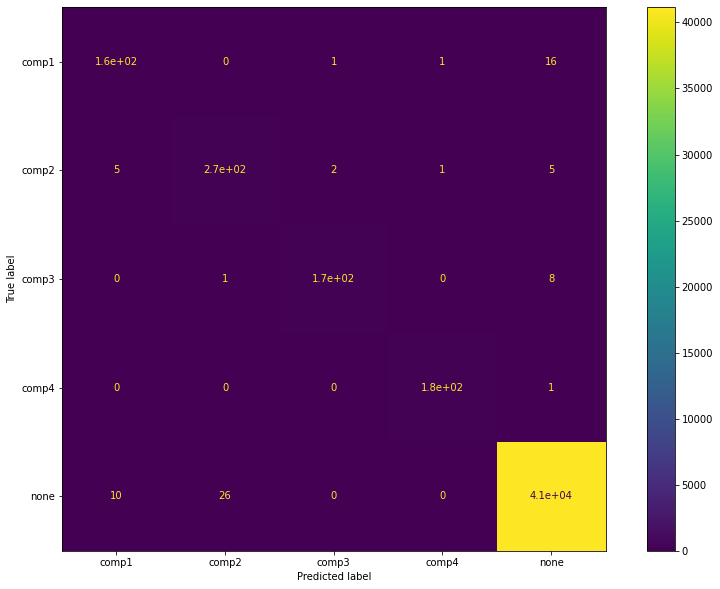

In [ ]:
rcParams['figure.figsize'] = 15,10
plot_confusion_matrix(model, X_test, y_true) 

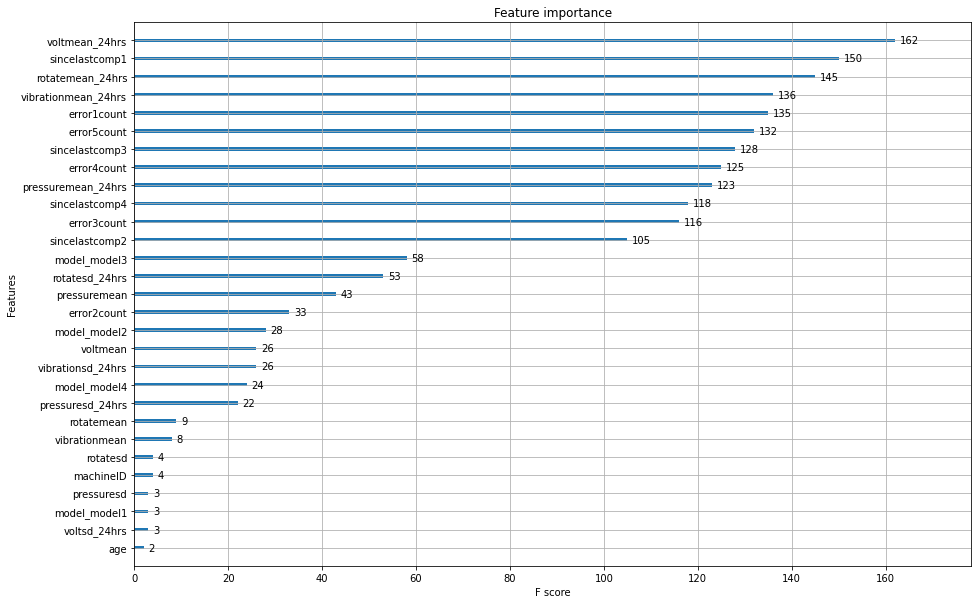

In [ ]:

plot_importance(model)


## Dataset 2

In [ ]:

# define dataset
t = trainingdata2.drop(columns=['datetime', 'failure'])
X, y =pd.get_dummies(t, 'model') , trainingdata2[['failure']]

t = testingdata2.drop(columns=['datetime', 'failure'])
X_test, y_true =pd.get_dummies(t, 'model') , testingdata2[['failure']]

# fit the model on the whole dataset
model = XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X_test)
print(classification_report(y_true, y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       comp1       0.88      0.91      0.90       149
       comp2       0.96      0.90      0.93       227
       comp3       0.98      0.95      0.96       151
       comp4       0.99      0.99      0.99       168
        none       1.00      1.00      1.00     33080

    accuracy                           1.00     33775
   macro avg       0.96      0.95      0.96     33775
weighted avg       1.00      1.00      1.00     33775



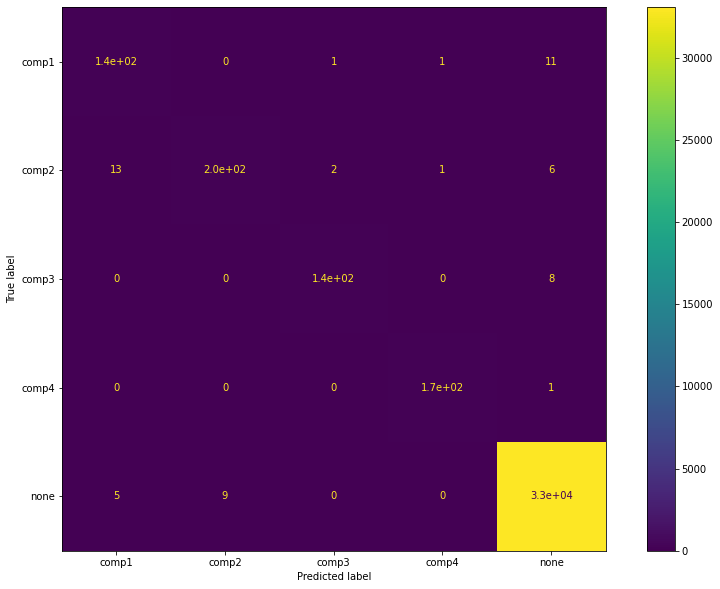

In [ ]:
plot_confusion_matrix(model, X_test, y_true) 

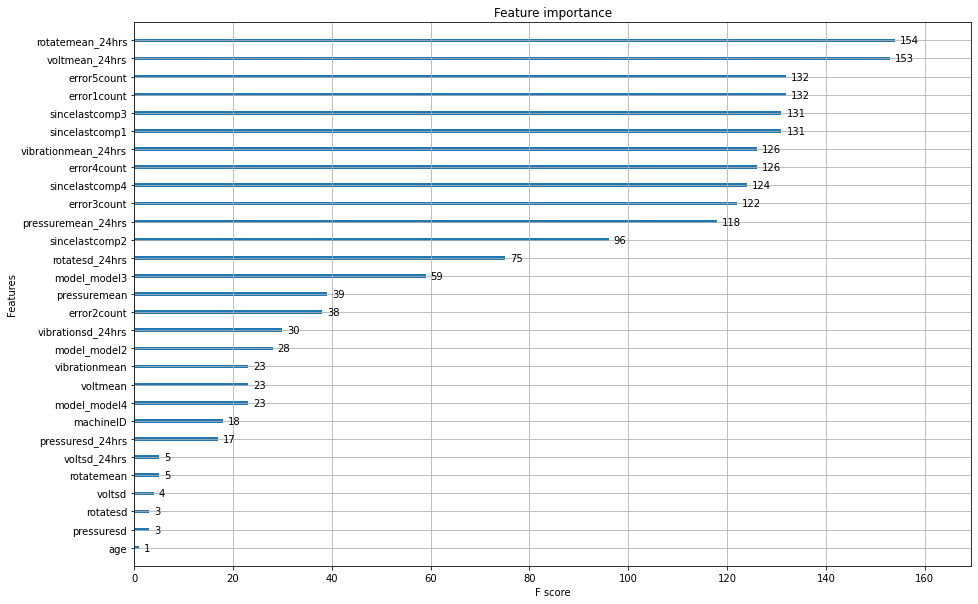

In [ ]:
plot_importance(model)

## Dataset 3

In [ ]:

# define dataset
t = trainingdata3.drop(columns=['datetime', 'failure'])
X, y =pd.get_dummies(t, 'model') , trainingdata3[['failure']]

t = testingdata3.drop(columns=['datetime', 'failure'])
X_test, y_true =pd.get_dummies(t, 'model') , testingdata3[['failure']]

# fit the model on the whole dataset
model = XGBClassifier()
model.fit(X, y)
y_pred = model.predict(X_test)
print(classification_report(y_true, y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       comp1       0.83      0.91      0.87        99
       comp2       0.96      0.91      0.94       179
       comp3       0.99      0.93      0.96       135
       comp4       0.99      1.00      1.00       120
        none       1.00      1.00      1.00     25348

    accuracy                           1.00     25881
   macro avg       0.96      0.95      0.95     25881
weighted avg       1.00      1.00      1.00     25881



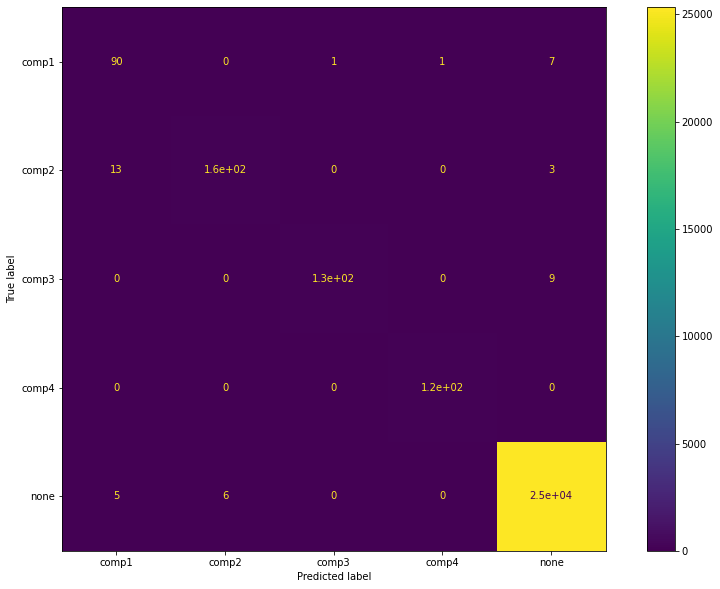

In [ ]:
plot_confusion_matrix(model, X_test, y_true) 

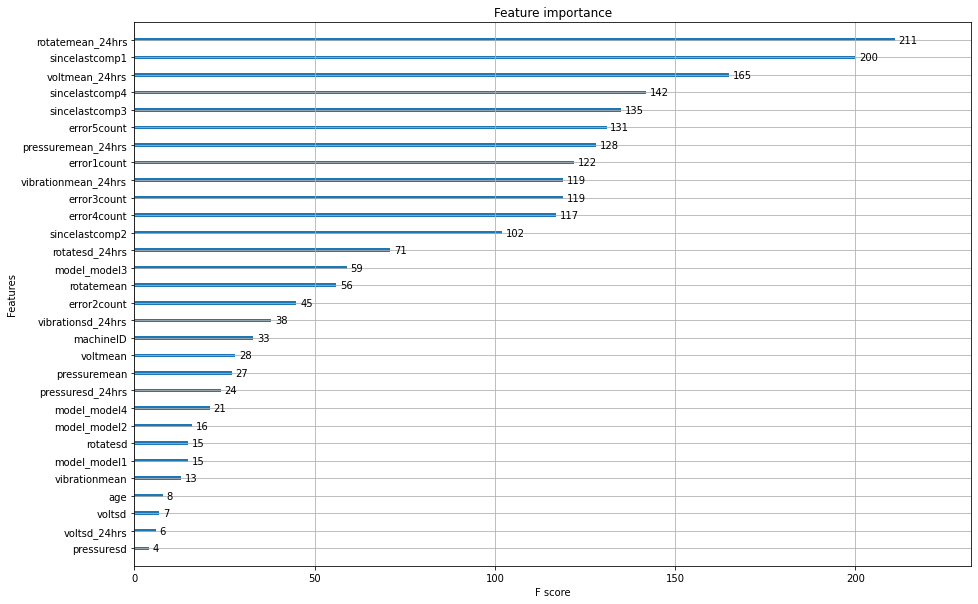

In [ ]:
plot_importance(model)